<a href="https://colab.research.google.com/github/KamilShape/twitter_sentiment_analysis/blob/main/twitter_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**TWITTER SENTIMENT ANALYSIS** 


The objective of this project is to develop a machine learning model that can predict tweet text class if there is negative or positive content. Database consist 1,600,000 datas. Naive Bayess, Logistic Regression and Neural Network are used for accurately predicting type of text .

Dataset description:
- 0 - the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
- 1 - the id of the tweet (2087)
- 2 - the date of the tweet (Sat May 16 23:58:44 UTC 2009)
- 3 - the query (lyx). If there is no query, then this value is NO_QUERY.
- 4 - the user that tweeted (robotickilldozr)
- 5 - the text of the tweet (Lyx is cool)

## **1. Importing and validation data**

In [1]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import string
import nltk
from nltk.tokenize import word_tokenize
import dask.dataframe as dd
import gensim.downloader as api
#----------------------------sklearn-----------------------------
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
#----------------------------keras-------------------------------
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.initializers import Constant
from keras.optimizers import Adam

In [2]:
COLUMNS = ['Polarity', 'ID', 'Date', 'Query', 'User_name', 'Text']
ENCODING = "ISO-8859-1"

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# before you load data, it's necessary to download them from github: https://github.com/KamilShape/twitter_sentiment_analysis and load into your google drive
tweets = pd.read_csv("/content/drive/MyDrive/twitter2.csv", encoding=ENCODING, names = COLUMNS )

In [5]:
tweets.head(10)

,Polarity,ID,Date,Query,User_name,Text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
9,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?


In [6]:
len(tweets)

1600000

#### 1.2 Dataset info:

In [7]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   Polarity   1600000 non-null  int64 
 1   ID         1600000 non-null  int64 
 2   Date       1600000 non-null  object
 3   Query      1600000 non-null  object
 4   User_name  1600000 non-null  object
 5   Text       1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [8]:
tweets.describe()

,Polarity,ID
count,1.600000e+06,1.600000e+06
mean,2.000000e+00,1.998818e+09
std,2.000001e+00,1.935761e+08
min,0.000000e+00,1.467810e+09
25%,0.000000e+00,1.956916e+09
50%,2.000000e+00,2.002102e+09
75%,4.000000e+00,2.177059e+09
max,4.000000e+00,2.329206e+09


#### 1.3 Checking null values:

In [9]:
np.sum(tweets.isnull().any(axis=1))

0

## **2. Data visualisation**

#### 2.1 Replacing positive value 4 to 1

In [10]:
tweets['Polarity'] = tweets['Polarity'].replace(4,1)

In [11]:
tweets['Polarity'].unique()

array([0, 1])

In [12]:
tweets_polarity = pd.DataFrame(tweets['Polarity'].value_counts()).reset_index()
tweets_polarity.columns = ['Polarity', 'Amount']

In [13]:
tweets_polarity

,Polarity,Amount
0,0,800000
1,1,800000


In [14]:
tweets_polarity['Polarity'].replace(0, 'Negative', inplace=True)

In [15]:
tweets_polarity['Polarity'].replace(1, 'Positive', inplace=True)

In [16]:
tweets_polarity

,Polarity,Amount
0,Negative,800000
1,Positive,800000


#### 2.2 Chart

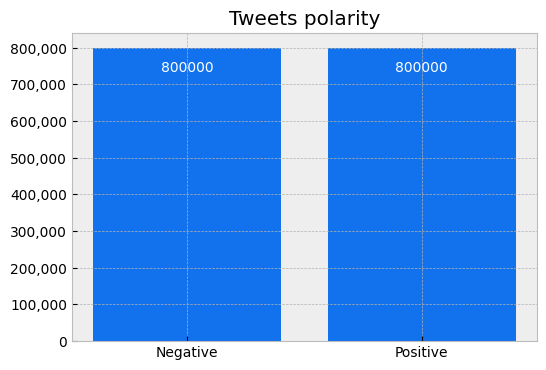

In [17]:
plt.style.use('bmh')
fig, ax=plt.subplots(figsize=(6,4))
ax.bar(tweets_polarity['Polarity'], tweets_polarity['Amount'], color='#1271ed')

ax.get_yaxis().set_major_formatter(
matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x)//1, ',')))
ax.set_title('Tweets polarity')

for i in range(0, len(tweets_polarity)):
  ax.text(tweets_polarity['Polarity'][i], tweets_polarity['Amount'][i]-65000, tweets_polarity['Amount'][i],
          horizontalalignment='center', color='w')

## **3. Data preprocessing**

#### **3.1 Selected columns**

In [18]:
tweets_data = tweets[['Polarity', 'Text']]

In [19]:
tweets_data.head(10)

,Polarity,Text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
5,0,@Kwesidei not the whole crew
6,0,Need a hug
7,0,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,@Tatiana_K nope they didn't have it
9,0,@twittera que me muera ?


#### 3.2 Making tweets text to lowercase

In [20]:
tweets_data['Text'] = tweets_data['Text'].str.lower()

<ipython-input-20-d870b1e4c535>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_data['Text'] = tweets_data['Text'].str.lower()


In [21]:
tweets_data.head(10)

,Polarity,Text
0,0,"@switchfoot http://twitpic.com/2y1zl - awww, t..."
1,0,is upset that he can't update his facebook by ...
2,0,@kenichan i dived many times for the ball. man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
5,0,@kwesidei not the whole crew
6,0,need a hug
7,0,@loltrish hey long time no see! yes.. rains a...
8,0,@tatiana_k nope they didn't have it
9,0,@twittera que me muera ?


#### 3.3 Removing punctuations

In [22]:
punctuation_list = string.punctuation

In [23]:
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', punctuation_list))  

In [24]:
tweets_data['Text'] = tweets_data['Text'].apply(lambda x: remove_punctuation(x))

<ipython-input-24-bde98e0cf2ff>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_data['Text'] = tweets_data['Text'].apply(lambda x: remove_punctuation(x))


#### 3.4 Removing stopwords

In [25]:
stopwords = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 
             'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [26]:
def delete_stopwords(txt):
    text = txt.split(" ")
    formated_text = [word for word in text if word not in stopwords]
    return " ".join(formated_text)

In [27]:
tweets_data['Text'] = tweets_data['Text'].apply(lambda x: delete_stopwords(x))

<ipython-input-27-baabe6ef86bb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_data['Text'] = tweets_data['Text'].apply(lambda x: delete_stopwords(x))


#### 3.5 Removing numbers

In [28]:
def remove_number(text):
    return re.sub('[0-9]+', '', text)

In [29]:
tweets_data['Text'] = tweets_data['Text'].apply(lambda x: remove_number(x))

<ipython-input-29-fa69f787bda1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_data['Text'] = tweets_data['Text'].apply(lambda x: remove_number(x))


Dask library is used in 3.6, 3.7 and 3.8 because of database is almost 230MB and participation makes colab work much faster.

#### 3.6 Tweets tokenization

In [30]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [31]:
tweets_data_dask = dd.from_pandas(tweets_data, npartitions=5)
tweets_data_dask['Text'] = tweets_data_dask['Text'].apply(lambda x: word_tokenize(x, language='english'))

/usr/local/lib/python3.10/dist-packages/dask/dataframe/core.py:4134: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('Text', 'object'))

  warnings.warn(meta_warning(meta))


In [32]:
tweets_data_tokenized = tweets_data_dask.compute()

In [33]:
tweets_data_tokenized.head(10)

,Polarity,Text
0,0,"[switchfoot, httptwitpiccomyzl, awww, thats, b..."
1,0,"[upset, cant, update, facebook, texting, might..."
2,0,"[kenichan, dived, many, times, ball, managed, ..."
3,0,"[whole, body, feels, itchy, like, fire]"
4,0,"[nationwideclass, no, not, behaving, im, mad, ..."
5,0,"[kwesidei, not, whole, crew]"
6,0,"[need, hug]"
7,0,"[loltrish, hey, long, time, no, see, yes, rain..."
8,0,"[tatianak, nope, didnt]"
9,0,"[twittera, que, muera]"


#### 3.7 Stemming

In [34]:
st = nltk.PorterStemmer()
def stemming_on_text(text):
    text = [st.stem(word) for word in text]
    return " ".join(text)

tweets_data_dask['Text']= tweets_data_dask['Text'].apply(lambda x: stemming_on_text(x))

/usr/local/lib/python3.10/dist-packages/dask/dataframe/core.py:4134: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('Text', 'object'))

  warnings.warn(meta_warning(meta))


#### 3.8 Lemmatization

In [35]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [36]:
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(text):
    text = [lm.lemmatize(word) for word in text]
    return " ".join(text)
tweets_data_dask['Text'] = tweets_data_dask['Text'].apply(lambda x: lm.lemmatize(x))

/usr/local/lib/python3.10/dist-packages/dask/dataframe/core.py:4134: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('Text', 'object'))

  warnings.warn(meta_warning(meta))


In [37]:
tweets_data_tokenized = tweets_data_dask.compute()

In [38]:
tweets_data.head(10)

,Polarity,Text
0,0,switchfoot httptwitpiccomyzl awww thats bumme...
1,0,upset cant update facebook texting might cry r...
2,0,kenichan dived many times ball managed save ...
3,0,whole body feels itchy like fire
4,0,nationwideclass no not behaving im mad cant se...
5,0,kwesidei not whole crew
6,0,need hug
7,0,loltrish hey long time no see yes rains bit b...
8,0,tatianak nope didnt
9,0,twittera que muera


## 4. Train and test split

In [39]:
X = tweets_data['Text']
y = tweets_data['Polarity']

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.1, random_state = 42)

In [41]:
print(X_train)

1205857                            saw picture heart melted 
20363                       ethanonly uni exam period   asot
902802                              jammin capital garde  xx
223111     talking mike skype greatest thing ever ohio fa...
12577      gosh dont hate guys damn perfect but never go ...
                                 ...                        
259178         songs middle change doesnt want born arghhhh 
1414414                            officialnjonas good luck 
131932                      proudgamertweet rather average  
671155     pickin misstinayao waitin sadittysash  hurry u...
121958        home studying maths wooot  im going fail shit 
Name: Text, Length: 1440000, dtype: object


## 5. TF-IDF Vectorizer

In [42]:
vectoriser = TfidfVectorizer(max_features=100000)
vectoriser.fit(X_train)

TfidfVectorizer(max_features=100000)

In [43]:
X_train = vectoriser.fit_transform(X_train)
X_test  = vectoriser.transform(X_test)

## 6. Classification models

#### 6.1 Naive Bayes Classifier

In [44]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
y_pred_nb = BNBmodel.predict(X_test)

In [45]:
print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

           0       0.78      0.78      0.78     79812
           1       0.78      0.78      0.78     80188

    accuracy                           0.78    160000
   macro avg       0.78      0.78      0.78    160000
weighted avg       0.78      0.78      0.78    160000



<Axes: >

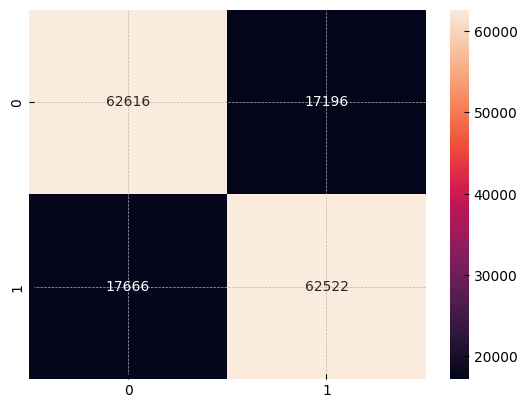

In [46]:
cm = confusion_matrix(y_test, y_pred_nb)
sns.heatmap(cm, annot = True, fmt=".0f")

 #### 6.2 Logistic Regresion 

In [47]:
LRmodel = LogisticRegression(max_iter = 1000)
LRmodel.fit(X_train, y_train)
y_pred_lr = LRmodel.predict(X_test)

In [48]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.80      0.78      0.79     79812
           1       0.79      0.81      0.80     80188

    accuracy                           0.80    160000
   macro avg       0.80      0.80      0.80    160000
weighted avg       0.80      0.80      0.80    160000



<Axes: >

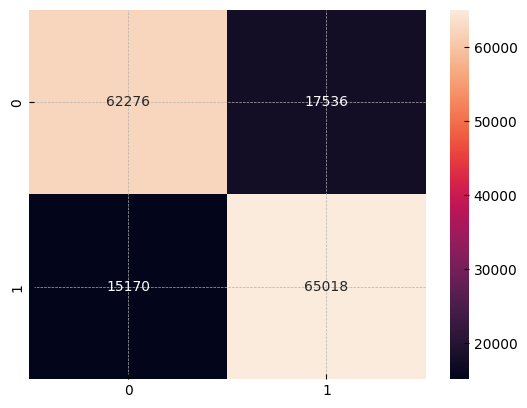

In [49]:
cm = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm, annot = True, fmt=".0f")

## 7. ROC Curves

#### 7.1 Pobabilities for positve test

In [50]:
nb_probs = BNBmodel.predict_proba(X_test)
lr_probs = LRmodel.predict_proba(X_test)
nb_probs = nb_probs[:,1]
lr_probs = lr_probs[:,1]

#### 7.2 ROC_curves and AUC_scores

In [51]:
help_prob=[0 for _ in range(len(y_test))]
nb_tpr, nb_fpr, _ = roc_curve(y_test, nb_probs)
lr_tpr, lr_fpr, _ = roc_curve(y_test, lr_probs)
help_tpr, help_fpr, _ = roc_curve(y_test, help_prob)

In [52]:
help_auc = roc_auc_score(y_test, help_prob)
nb_auc = roc_auc_score(y_test, nb_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

#### 7.3 Chart

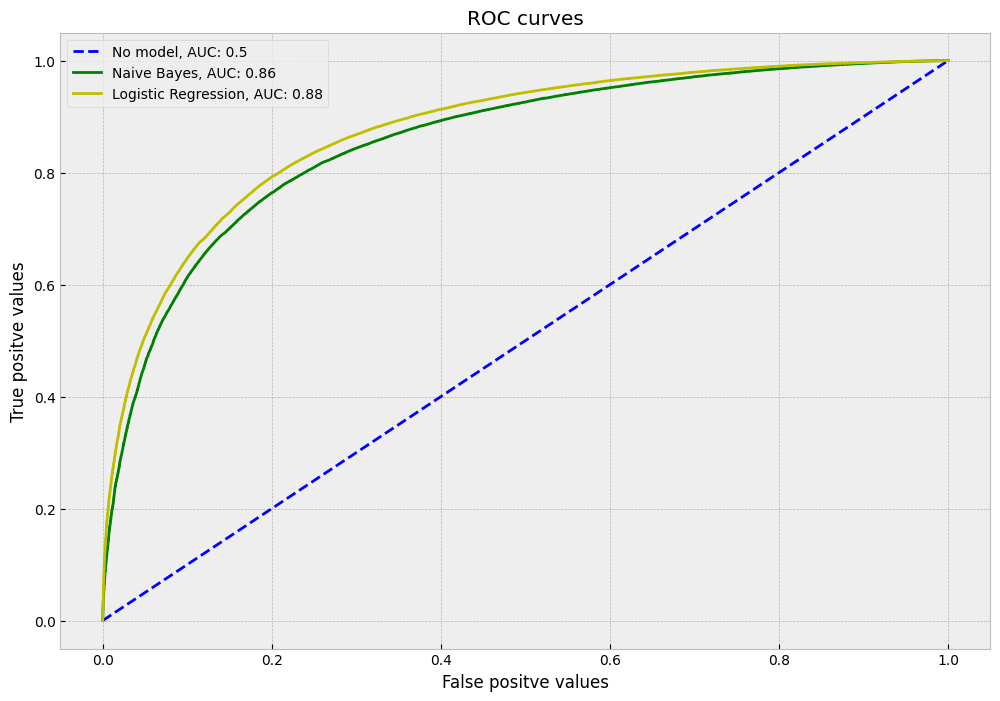

In [53]:
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(help_tpr, help_fpr, label = f'No model, AUC: {round(help_auc, 2)}', color='b', linestyle='--')
ax.plot(nb_tpr, nb_fpr, label = f'Naive Bayes, AUC: {round(nb_auc, 2)}', color='g')
ax.plot(lr_tpr, lr_fpr, label = f'Logistic Regression, AUC: {round(lr_auc, 2)}', color = 'y')
ax.set_title('ROC curves')
ax.set_xlabel('False positve values')
ax.set_ylabel('True positve values')
ax.legend()

## 8. Neural Network

#### 8.1 Tokenization

In [54]:
text = tweets_data['Text']
labels = tweets_data['Polarity']

In [55]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text)
sequences = tokenizer.texts_to_sequences(text)

In [56]:
word_index = tokenizer.word_index

#### 8.2 Train, test, validation split

In [57]:
data = pad_sequences(sequences)

In [58]:
X_train, X_test, y_train, y_test = train_test_split(data, labels,
    test_size=0.2, shuffle = True, random_state = 8)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
    test_size=0.25, random_state= 8)

In [59]:
max_length = data.shape[1]
vocab_size = len(word_index)
embedding_dim = 150

#### 8.3 Model

In [90]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(LSTM(200, dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

In [91]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [92]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size = 10000, verbose=2)

Epoch 1/10
96/96 - 52s - loss: 0.5571 - accuracy: 0.7221 - val_loss: 0.4599 - val_accuracy: 0.7880 - 52s/epoch - 542ms/step
Epoch 2/10
96/96 - 44s - loss: 0.4247 - accuracy: 0.8090 - val_loss: 0.4416 - val_accuracy: 0.7966 - 44s/epoch - 457ms/step
Epoch 3/10
96/96 - 42s - loss: 0.3686 - accuracy: 0.8404 - val_loss: 0.4565 - val_accuracy: 0.7906 - 42s/epoch - 441ms/step
Epoch 4/10
96/96 - 40s - loss: 0.3379 - accuracy: 0.8612 - val_loss: 0.4819 - val_accuracy: 0.7864 - 40s/epoch - 420ms/step
Epoch 5/10
96/96 - 38s - loss: 0.2721 - accuracy: 0.8882 - val_loss: 0.5051 - val_accuracy: 0.7826 - 38s/epoch - 397ms/step
Epoch 6/10
96/96 - 39s - loss: 0.2384 - accuracy: 0.9031 - val_loss: 0.5270 - val_accuracy: 0.7796 - 39s/epoch - 405ms/step
Epoch 7/10
96/96 - 38s - loss: 0.2153 - accuracy: 0.9126 - val_loss: 0.5593 - val_accuracy: 0.7784 - 38s/epoch - 396ms/step
Epoch 8/10
96/96 - 37s - loss: 0.1971 - accuracy: 0.9191 - val_loss: 0.6104 - val_accuracy: 0.7770 - 37s/epoch - 384ms/step
Epoch 9/

#### 8.4 Learning curve

In [93]:
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

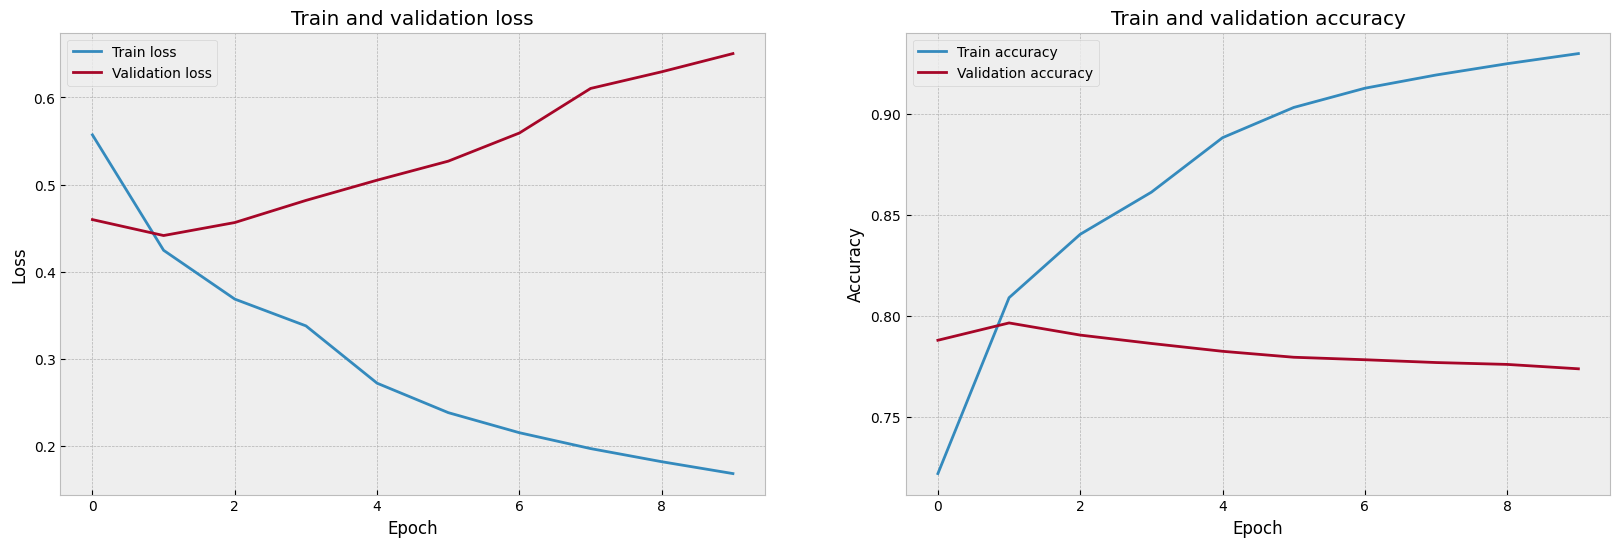

In [94]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,6))
ax1.set_title('Train and validation loss')
ax1.plot(train_loss, label='Train loss')
ax1.plot(val_loss, label = 'Validation loss')
ax2.set_title('Train and validation accuracy')
ax2.plot(train_accuracy, label='Train accuracy')
ax2.plot(val_accuracy, label = 'Validation accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax1.legend()
ax2.legend()